# Appendix II: Feature Engineering

Because the aim of this survey is inferential in nature, features were engineered with interpretability in mind.

We start with initial imports and file reads. Where relevant, the test dataset receives treatment identical to that of the training dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
train = pd.read_csv('../datasets/main_train.csv')
test = pd.read_csv('../datasets/main_test.csv')

train.drop(columns=['pid'], inplace = True)
test.drop(columns=['pid'], inplace = True)

The testing dataset had many problematic cells, resulting in a disparity of datatypes between itself and the training data. Below, a brief function allows for conversions and reasonable imputations where necessary so that the columns can "function numerically" with the resultant model.

In [3]:
def to_float(x):
    try:
        return float(x)
    except:
        return 0

In [4]:
test['lot_frontage'].replace('Unknown', 0, inplace = True)
test['lot_frontage'] = test['lot_frontage'].astype(float)

test['lot_area'].replace('Unknown', 0, inplace = True)
test['lot_area'] = test['lot_area'].astype(int)

test['overall_qual'].replace('Unknown', 5, inplace = True)
test['overall_qual'] = test['overall_qual'].astype(int)

test['overall_cond'].replace('Unknown', 5, inplace = True)
test['overall_cond'] = test['overall_cond'].astype(int)

test['year_built'].replace('Unknown', 1960, inplace = True)
test['year_built'] = test['year_built'].astype(int)

test['year_remod/add'].replace('Unknown', 1960, inplace = True)
test['year_remod/add'] = test['year_remod/add'].astype(int)



test['mas_vnr_area'] = test['mas_vnr_area'].apply(to_float)
test['bsmtfin_sf_1'] = test['bsmtfin_sf_1'].apply(to_float)
test['bsmtfin_sf_2'] = test['bsmtfin_sf_2'].apply(to_float)
test['bsmt_unf_sf'] = test['bsmt_unf_sf'].apply(to_float)
test['total_bsmt_sf'] = test['total_bsmt_sf'].apply(to_float)
test['1st_flr_sf'] = test['1st_flr_sf'].apply(to_float).astype(int)
test['2nd_flr_sf'] = test['2nd_flr_sf'].apply(to_float).astype(int)
test['low_qual_fin_sf'] = test['low_qual_fin_sf'].apply(to_float).astype(int)
test['gr_liv_area'] = test['gr_liv_area'].apply(to_float).astype(int)
test['bsmt_full_bath'] = test['bsmt_full_bath'].apply(to_float)
test['bsmt_half_bath'] = test['bsmt_half_bath'].apply(to_float)
test['full_bath'] = test['full_bath'].apply(to_float).astype(int)
test['half_bath'] = test['half_bath'].apply(to_float).astype(int)
test['bedroom_abvgr'] = test['bedroom_abvgr'].apply(to_float).astype(int)
test['kitchen_abvgr'] = test['kitchen_abvgr'].apply(to_float).astype(int)
test['totrms_abvgrd'] = test['totrms_abvgrd'].apply(to_float).astype(int)
test['fireplaces'] = test['fireplaces'].apply(to_float).astype(int)
test['garage_cars'] = test['garage_cars'].apply(to_float)
test['garage_area'] = test['garage_area'].apply(to_float)

Both datasets drop the `ms_subclass` column:

In [5]:
train.drop(columns=['ms_subclass'], inplace = True)
test.drop(columns=['ms_subclass'], inplace = True)

In [6]:
trn = train._get_numeric_data()
tst = test._get_numeric_data()

The EDA process included toying with various combinations of values related to the square footage of different property areas, and the columns generated here reflect this:

In [7]:
trn['total_sf'] = train['1st_flr_sf'] + train['2nd_flr_sf'] + train['total_bsmt_sf']
trn['total_bth'] = train['bsmt_full_bath'] + train['bsmt_half_bath'] + train['full_bath'] + train['half_bath']
trn['total_bth/sf'] = trn['total_bth'] / trn['total_sf']
trn['total_bed/sf'] = trn['bedroom_abvgr'] / trn['total_sf']

tst['total_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf'] + test['total_bsmt_sf']
tst['total_bth'] = test['bsmt_full_bath'] + test['bsmt_half_bath'] + test['full_bath'] + test['half_bath']
tst['total_bth/sf'] = tst['total_bth'] / tst['total_sf']
tst['total_bed/sf'] = tst['bedroom_abvgr'] / tst['total_sf']

The survey explored potential logarithmic relationships as well wherever an absence of zero values allowed:

In [8]:
trn_log = pd.DataFrame()
trn_log['sale_price'] = trn['sale_price']

for item in trn.columns.tolist():
    if 0 not in trn[item].tolist():
        trn_log[item] = np.log(trn[item])
        
tst_log = pd.DataFrame()

for item in tst.columns.tolist():
    if 0 not in tst[item].tolist():
        tst_log[item] = np.log(tst[item])

Below, the relationship between neighborhood and selling price is explored. The dictionary receives an index of all neighborhoods, sorted by relative property value, and the following cell writes a [`scatterplot`](../visualizations/05_price_vs_nbhd_idx.png) to the `visualizations` folder. The graph bears witness to a neatly gradated relationship, and neighborhood thus serves a large role in the final model.

In [9]:
nbdct1 = {}

for i in range(len(train.groupby('neighborhood')['sale_price'].mean().sort_values(ascending = False))):
    nbdct1[i] = train.groupby('neighborhood')['sale_price'].mean().sort_values(ascending = False)[i]

In [10]:
plt.figure(figsize = (9,5))
plt.scatter(nbdct1.keys(), nbdct1.values())
plt.title('Avg. Property Selling Price vs. Neighborhood Index',fontsize=17)
plt.xlabel('Neighborhood Index')
plt.ylabel('Avg. Selling Price (in Dollars)')
plt.savefig('../visualizations/05_price_vs_nbhd_idx')
plt.close();

The function below and its call index each neighborhood according to desirability, allowing for subsequent dummying later on.

In [11]:
def to_nbhd_rank(nbhd):
    try:
        return nbhd_dict[nbhd]
    except:
        return 13

def to_nbhd_index(rank):
    index = 0
    
    if rank < 3 :
        index = 1
    elif rank < 8:
        index = 2
    elif rank < 15:
        index = 3
    elif rank == 15:
        index = 4
    elif rank < 24:
        index = 5
    else:
        index = 6
    
    return index

In [12]:
nbhd_dict = {}
for i in range(len(train.groupby('neighborhood')['sale_price'].mean().sort_values(ascending = False))):
    nbhd_dict[train.groupby('neighborhood')['sale_price'].mean().sort_values(ascending = False).index[i]] = i
    
train['nbhd_rank'] = train['neighborhood'].apply(to_nbhd_rank)
train['nbhd_rank_idx'] = train['nbhd_rank'].apply(to_nbhd_index)

test['nbhd_rank'] = test['neighborhood'].apply(to_nbhd_rank)
test['nbhd_rank_idx'] = test['nbhd_rank'].apply(to_nbhd_index)

Similarly, the `sale_type` variable is essentially converted from a word-based string to a set of numerical values.

In [13]:
def to_sale_rank(sale):
    try:
        return sale_dict[sale]
    except:
        return 4

In [14]:
sale_dict = {}
for i in range(len(train.groupby('sale_type')['sale_price'].mean().sort_values(ascending = False))):
    sale_dict[train.groupby('sale_type')['sale_price'].mean().sort_values(ascending = False).index[i]] = i
    
trn['sale_code'] = train['sale_type'].apply(to_sale_rank)
tst['sale_code'] = test['sale_type'].apply(to_sale_rank)

Dummies are created for the neighborhood index in both the training and testing data.

In [15]:
trn['neighborhood'] = train['neighborhood']
trn['nbhd_rank'] = train['nbhd_rank']
trn['nbhd_rank_idx'] = train['nbhd_rank_idx']
trn = pd.merge( left = trn, 
                right = pd.get_dummies(trn['nbhd_rank_idx'], prefix = 'nbhd_rank_idx'), 
                how='inner', 
                left_index = True, 
                right_index = True)

tst['neighborhood'] = test['neighborhood']
tst['nbhd_rank'] = test['nbhd_rank']
tst['nbhd_rank_idx'] = test['nbhd_rank_idx']
tst = pd.merge( left = tst, 
                right = pd.get_dummies(tst['nbhd_rank_idx'], prefix = 'nbhd_rank_idx'), 
                how='inner', 
                left_index = True, 
                right_index = True)

Zone type is encoded numerically:

In [16]:
def to_zone_rank(zone):
    try:
        return zone_dict[zone]
    except:
        return 3

In [17]:
zone_dict = {}

for i in range(len(train.groupby('ms_zoning')['sale_price'].mean().sort_values(ascending = False))):
    zone_dict[train.groupby('ms_zoning')['sale_price'].mean().sort_values(ascending = False).index[i]] = i
    
trn['zone_code'] = train['ms_zoning'].apply(to_zone_rank)
tst['zone_code'] = test['ms_zoning'].apply(to_zone_rank)

In the tradition of throwing everything at a wall to see what sticks, dummies are created for whether or not a property has central air and whether or not the driveway is paved:

In [18]:
trn = pd.merge( left = trn, 
                right = pd.get_dummies(train['central_air'], prefix = 'A/C', drop_first = True), 
                how='inner', 
                left_index = True, 
                right_index = True)

tst = pd.merge( left = tst, 
                right = pd.get_dummies(test['central_air'], prefix = 'A/C', drop_first = True), 
                how='inner', 
                left_index = True, 
                right_index = True)

In [19]:
trn = pd.merge(left = trn, 
         right = pd.get_dummies(train['paved_drive'], 
         prefix = 'pvddrv'), how='inner', 
         left_index = True, right_index = True).drop(columns=['pvddrv_N', 'pvddrv_P'])

tst = pd.merge(left = tst, 
         right = pd.get_dummies(test['paved_drive'], 
         prefix = 'pvddrv'), how='inner', 
         left_index = True, right_index = True).drop(columns=['pvddrv_N', 'pvddrv_P'])

Many qualitative variables are numerically encoded for exploration, including land contour and kitchen quality:

In [20]:
trn['ex_kitch'] = train['kitchen_qual'].map(lambda x: 1 if x == 'Ex' else 0)
trn['is_flat'] = train['land_contour'].map(lambda x: 1 if x == 'Lvl' else 0)
trn['func_typ'] = train['functional'].map(lambda x: 1 if x == 'Typ' else 0)
trn['ex_ext'] = train['exter_cond'].map(lambda x: 1 if x == 'Ex' else 0)
trn['zoning'] = train['ms_zoning'].map(lambda x: 'R' if x == 'FV' or x == 'RH'
                                         or x == 'RL' or x == 'RP' or x =='RM' else x)

tst['ex_kitch'] = test['kitchen_qual'].map(lambda x: 1 if x == 'Ex' else 0)
tst['is_flat'] = test['land_contour'].map(lambda x: 1 if x == 'Lvl' else 0)
tst['func_typ'] = test['functional'].map(lambda x: 1 if x == 'Typ' else 0)
tst['ex_ext'] = test['exter_cond'].map(lambda x: 1 if x == 'Ex' else 0)
tst['zoning'] = test['ms_zoning'].map(lambda x: 'R' if x == 'FV' or x == 'RH'
                                         or x == 'RL' or x == 'RP' or x =='RM' else x)

Zones receive dummy columns in addition to their index:

In [21]:
trn = pd.merge( left = trn, 
                right = pd.get_dummies(trn['zoning'], prefix = 'zne', drop_first = True), 
                how='inner', 
                left_index = True, 
                right_index = True)

tst = pd.merge( left = tst, 
                right = pd.get_dummies(tst['zoning'], prefix = 'zne', drop_first = True), 
                how='inner', 
                left_index = True, 
                right_index = True)

Combining information from two columns related to nearby amenities, each dataset receives a single dummy column (by way of adding, dividing, and rounding dummy conversion columns) reflecting whether or not there are notable positive features in the vicinity of a given property. Again, the two intial columns are dummied, then added and divided, so where either column is `True`, a value results that rounds to `1`).

In [22]:
trn['cond1_A'] = train['condition_1'].map(lambda x: 1 if x == 'PosA' else 0)
trn['cond1_N'] = train['condition_1'].map(lambda x: 1 if x == 'PosN' else 0)
trn['cond2_A'] = train['condition_2'].map(lambda x: 1 if x == 'PosA' else 0)
trn['cond2_N'] = train['condition_2'].map(lambda x: 1 if x == 'PosN' else 0)
trn['PosA'] = round((trn['cond1_A'] + trn['cond2_A'])/2)
trn['PosN'] = round((trn['cond1_N'] + trn['cond2_N'])/2)
trn['pos_a/n'] = round((trn['PosA'] + trn['PosN'])/2)

tst['cond1_A'] = test['condition_1'].map(lambda x: 1 if x == 'PosA' else 0)
tst['cond1_N'] = test['condition_1'].map(lambda x: 1 if x == 'PosN' else 0)
tst['cond2_A'] = test['condition_2'].map(lambda x: 1 if x == 'PosA' else 0)
tst['cond2_N'] = test['condition_2'].map(lambda x: 1 if x == 'PosN' else 0)
tst['PosA'] = round((tst['cond1_A'] + tst['cond2_A'])/2)
tst['PosN'] = round((tst['cond1_N'] + tst['cond2_N'])/2)
tst['pos_a/n'] = round((tst['PosA'] + tst['PosN'])/2)

More everything-and-the-kitchen-sink Booleans for consideration. There was often a great deal of overlap in the types of information various columns reflected, with the intention of fine-tuning the final model as best as possible.

In [23]:
trn['has_pool'] = train['pool_area'].map(lambda x: 1 if x > 0 else 0)
trn['good_pool'] = train['pool_qc'].map(lambda x: 1 if x == 'Ex' or x == 'Gd' else 0)
trn['sale_high'] = train['sale_type'].map(lambda x: 1 if x == 'New' or x == 'Con' else 0)
trn['good_roof'] = train['roof_style'].map(lambda x: 1 if x =='Hip' else 0)
trn['2story'] = trn['2nd_flr_sf'].map(lambda x: 1 if x > 0 else 0)
trn['feats'] = train['misc_feature'].map(lambda x: 0 if x =='Shed' or x =='None' else 1)
trn['good_bsmt'] = train['bsmt_cond'].map(lambda x: 0 if x =='Ex' or x =='Gd' else 1)
trn['good_fire'] = train['fireplace_qu'].map(lambda x: 0 if x =='Ex' or x =='Gd' else 1)
trn['good_grg'] = train['garage_cond'].map(lambda x: 0 if x =='Ex' or x =='Gd' or x == 'Fair' else 1)

tst['has_pool'] = test['pool_area'].map(lambda x: 1 if x > 0 else 0)
tst['good_pool'] = test['pool_qc'].map(lambda x: 1 if x == 'Ex' or x == 'Gd' else 0)
tst['sale_high'] = test['sale_type'].map(lambda x: 1 if x == 'New' or x == 'Con' else 0)
tst['good_roof'] = test['roof_style'].map(lambda x: 1 if x =='Hip' else 0)
tst['2story'] = tst['2nd_flr_sf'].map(lambda x: 1 if x > 0 else 0)
tst['feats'] = test['misc_feature'].map(lambda x: 0 if x =='Shed' or x =='None' else 1)
tst['good_bsmt'] = test['bsmt_cond'].map(lambda x: 0 if x =='Ex' or x =='Gd' else 1)
tst['good_fire'] = test['fireplace_qu'].map(lambda x: 0 if x =='Ex' or x =='Gd' else 1)
tst['good_grg'] = test['garage_cond'].map(lambda x: 0 if x =='Ex' or x =='Gd' or x == 'Fair' else 1)

As mentioned in [`the primary summary notebook`](../main.ipynb), there was some experimenting with gradations of dummying based on the unique distribution of data for `year_built` and `year_remod/add`. Ultimatey, only the dummy columns related to "newness" were used. That is, whether or not a property was built or remodeled since the year 2000 became a factor in the final model.

In [24]:
trn['is_new'] = trn['year_built'].map(lambda x:  1 if x > 2000 else 0 )
trn = pd.merge( left = trn, 
                right = pd.get_dummies(trn['is_new'], prefix = 'is_new'), 
                how='inner', 
                left_index = True, 
                right_index = True)
trn['old_val'] = trn['year_built'] * trn['is_new_0']
trn.drop(columns = ['is_new_0'], inplace = True)

tst['is_new'] = tst['year_built'].map(lambda x:  1 if x > 2000 else 0 )
tst = pd.merge( left = tst, 
                right = pd.get_dummies(trn['is_new'], prefix = 'is_new'), 
                how='inner', 
                left_index = True, 
                right_index = True)
tst['old_val'] = tst['year_built'] * tst['is_new_0']
tst.drop(columns = ['is_new_0'], inplace = True)

In [25]:
trn['is_new_rem'] = trn['year_remod/add'].map(lambda x:  1 if x > 2000 else 0 )
trn = pd.merge( left = trn, 
                right = pd.get_dummies(trn['is_new_rem'], prefix = 'is_new_rem'), 
                how='inner', 
                left_index = True, 
                right_index = True)
trn['old_rem'] = trn['year_built'] * trn['is_new_rem_0']
trn.drop(columns = ['is_new_rem_0'], inplace = True)

tst['is_new_rem'] = tst['year_remod/add'].map(lambda x:  1 if x > 2000 else 0 )
tst = pd.merge( left = tst, 
                right = pd.get_dummies(tst['is_new_rem'], prefix = 'is_new_rem'), 
                how='inner', 
                left_index = True, 
                right_index = True)
tst['old_rem'] = tst['year_built'] * tst['is_new_rem_0']
tst.drop(columns = ['is_new_rem_0'], inplace = True)

The catch-all function here allows numerical encoding of the quality/condition of various aspects of each property, allowing for meaningful evaluation by the linear regression model.

In [26]:
def cond_ind(x):
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'Fa':
        return 3
    elif x == 'TA':
        return 2
    elif x == 'Po':
        return 1
    else:
        return 0

Here the quality/condition of the exterior, the basement, the fireplace, the garage, the pool, and the kitchen are encoded with the above function respectively.

In [27]:
trn['ext_code'] = train['exter_cond'].apply(cond_ind)
trn['bsmt_code'] = train['bsmt_cond'].apply(cond_ind)
trn['fire_code'] = train['fireplace_qu'].apply(cond_ind)
trn['grg_code'] = train['garage_cond'].apply(cond_ind)
trn['pool_code'] = train['pool_qc'].apply(cond_ind)
trn['ktch_code'] = train['kitchen_qual'].apply(cond_ind)

tst['ext_code'] = test['exter_cond'].apply(cond_ind)
tst['bsmt_code'] = test['bsmt_cond'].apply(cond_ind)
tst['fire_code'] = test['fireplace_qu'].apply(cond_ind)
tst['grg_code'] = test['garage_cond'].apply(cond_ind)
tst['pool_code'] = test['pool_qc'].apply(cond_ind)
tst['ktch_code'] = test['kitchen_qual'].apply(cond_ind)

Values of `0` in the test data allowed only one logarithmic value to make it to the winners' circle:

In [28]:
trn['log_qual'] = trn_log['overall_qual']
tst['log_qual'] = tst_log['overall_qual']

As in the summary notebook, a function is created here for testing purposes. Essentially, for any set of independent variables and their dependent variable, the function runs a linear regression model (complete with a train-test-split and cross-validation mechanism) and tracks relevant metrics. Because results can vary somewhat depending on the throw of the dice, linear regression is run five times, with the metrics being logged in their respective lists, and the averages are printed for the user.

In [29]:
def lin_reg(X, y):
    lr = LinearRegression()

    r2_train_list = []
    r2_test_list = []
    r2_diff_list = []
    rmse_list = []
    cv_mean_list = []
    
    for n in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        lr.fit(X_train, y_train)
        r2_train_list.append(lr.score(X_train, y_train))
        r2_test_list.append(lr.score(X_test, y_test))
        r2_diff_list.append(r2_train_list[-1] - r2_test_list[-1])
        cv_mean_list.append(cross_val_score(estimator=lr, X = X_train, y= y_train, cv = 5, n_jobs = -1).mean())
        residuals = y_test - lr.predict(X_test)
        rmse_list.append((sum(residuals**2)/len(residuals))**0.5)
    
    print('For the training data, the mean score is ', pd.Series(r2_train_list).mean(), ' and a median of ', pd.Series(r2_train_list).median(),
         ' with a standard deviation of ', pd.Series(r2_train_list).std(), ' a minimum of ', 
          pd.Series(r2_train_list).min(), ' and a maximum of ', pd.Series(r2_train_list).max(), '.\n')

    print('For the testing data, the mean score is ', pd.Series(r2_test_list).mean(), ' and a median of ', pd.Series(r2_test_list).median(),
         ' with a standard deviation of ', pd.Series(r2_test_list).std(), ' a minimum of ', 
          pd.Series(r2_test_list).min(), ' and a maximum of ', pd.Series(r2_test_list).max(), '.\n')

    print('For cross validation, the mean of means is ', pd.Series(cv_mean_list).mean(), ' and the median is ', pd.Series(cv_mean_list).median(),
         ' with a standard deviation of ', pd.Series(cv_mean_list).std(), ' a minimum of ', 
          pd.Series(cv_mean_list).min(), ' and a maximum of ', pd.Series(cv_mean_list).max(), '.\n')
    
    print('For the train to test difference, the mean difference is ', pd.Series(r2_diff_list).mean(), ' and a median of ', pd.Series(r2_diff_list).median(),
         ' with a standard deviation of ', pd.Series(r2_diff_list).std(), ' a minimum of ', 
          pd.Series(r2_diff_list).min(), ' and a maximum of ', pd.Series(r2_diff_list).max(), '.\n')

    print('For the RMSE, the mean is ', pd.Series(rmse_list).mean(), ' and a median of ', pd.Series(rmse_list).median(),
         ' with a standard deviation of ', pd.Series(rmse_list).std(), ' a minimum of ', 
          pd.Series(rmse_list).min(), ' and a maximum of ', pd.Series(rmse_list).max(), '.\n')

The stages through which the model for this survey developed are described in greater detail in the summary notebook, but ultimately, values related to space, age, neighborhood, amenities, and condition are ultimately given the most treatment. Below are the variables that the model considers in its final form:

In [30]:
lin_reg(trn[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf',
            'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
            'bsmt_code', 'grg_code', 'sale_code',
             'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6',
            'total_bth', 'pos_a/n', 'ex_kitch', 'log_qual', 'is_new', 'is_new_rem']],
        trn['sale_price'])

For the training data, the mean score is  0.840946816860713  and a median of  0.8423253202641888  with a standard deviation of  0.004386636492752717  a minimum of  0.8336700948219482  and a maximum of  0.8444026765889181 .

For the testing data, the mean score is  0.8603744678229445  and a median of  0.8546519950937538  with a standard deviation of  0.013129568455952494  a minimum of  0.8515241504503652  and a maximum of  0.8828113225253744 .

For cross validation, the mean of means is  0.8234176545083587  and the median is  0.8226350736442696  with a standard deviation of  0.005503047961854022  a minimum of  0.8158302016590945  and a maximum of  0.829635671371625 .

For the train to test difference, the mean difference is  -0.01942765096223158  and a median of  -0.012326674829564954  with a standard deviation of  0.01749883663450063  a minimum of  -0.049141227703426216  and a maximum of  -0.007121473861447125 .

For the RMSE, the mean is  29857.034576744772  and a median of  29809.223

Among "improvable" variables, kitchen condition and firepace condition are the most significant.

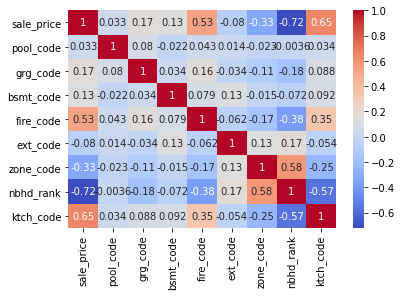

In [31]:
qual_codes = trn[['sale_price', 'pool_code', 'grg_code', 'bsmt_code', 'fire_code', 'ext_code', 
                  'zone_code', 'nbhd_rank', 'ktch_code']]
sns.heatmap(qual_codes.corr(), annot=True, cmap='coolwarm');

Below, the model is run for the test dataset in compliance with Kaggle. All relevant steps have been performed identically on all data, and the estimates generate smoothly:

In [32]:
lr = LinearRegression()
lr.fit(trn[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf',
            'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
            'bsmt_code', 'grg_code', 'sale_code',
             'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6',
            'total_bth', 'pos_a/n', 'ex_kitch', 'log_qual', 'is_new', 'is_new_rem']],
        trn['sale_price'])

tst['estimates'] = lr.predict(tst[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf',
            'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
            'bsmt_code', 'grg_code', 'sale_code',
             'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6',
            'total_bth', 'pos_a/n', 'ex_kitch', 'log_qual', 'is_new', 'is_new_rem']])
tst['id'] = pd.read_csv('../datasets/main_test.csv')['id']

tst[['id', 'estimates']]

,id,estimates
0,2658,151648.812499
1,2718,183752.919258
2,2414,206243.229876
3,1989,115151.597682
4,625,175244.795022
...,...,...
873,1662,198144.208579
874,1234,188488.679650
875,1373,119404.814385
876,1672,99342.795871


The newly revised test dataset is passed to an external file for some [`light cosmetic changes`](../appendices/03_kaggle.ipynb) as is the final training dataset from which the summary notebook derives its results.

In [33]:
tst.to_csv('../datasets/base_submit.csv') 
trn.to_csv('../datasets/final_train.csv')